In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20201002_feature_dropout"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
train_dict = np.load(NPZ_DIR + '20200930_multiplex_train_split.npz', allow_pickle=True)['0.005'].item()
val_dict = np.load(NPZ_DIR + '20200930_multiplex_val_split.npz', allow_pickle=True)['0.005'].item()

In [4]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200930_multiplex_"

#train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz")
#val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz")
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

In [5]:
X_train = multiplex_preprocess(X_train)
X_val = multiplex_preprocess(X_val)

In [6]:
print(X_train.shape, X_val.shape)

(12, 512, 512, 2) (15, 256, 256, 2)


In [7]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W1002 19:46:48.987863 139992054073152 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + 'deep_watershed_single_batch_lr_4_batch_1'

n_epoch = 250  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 1

min_objects = 0  # throw out images with fewer than this many objects
seed=0
model_name

'20200930_multiplex_deep_watershed_single_batch_lr_4_batch_1'

In [9]:
from deepcell import image_generators
from deepcell.utils import train_utils


#use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256),
    float_dtype='float16',
    int_dtype='int16')

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    float_dtype='float16',
    int_dtype='int16')    

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
#     transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
#     transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
#                       'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
#     transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
#     transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
#                       'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

W1002 19:47:21.662167 139992054073152 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype
W1002 19:47:23.319122 139992054073152 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype


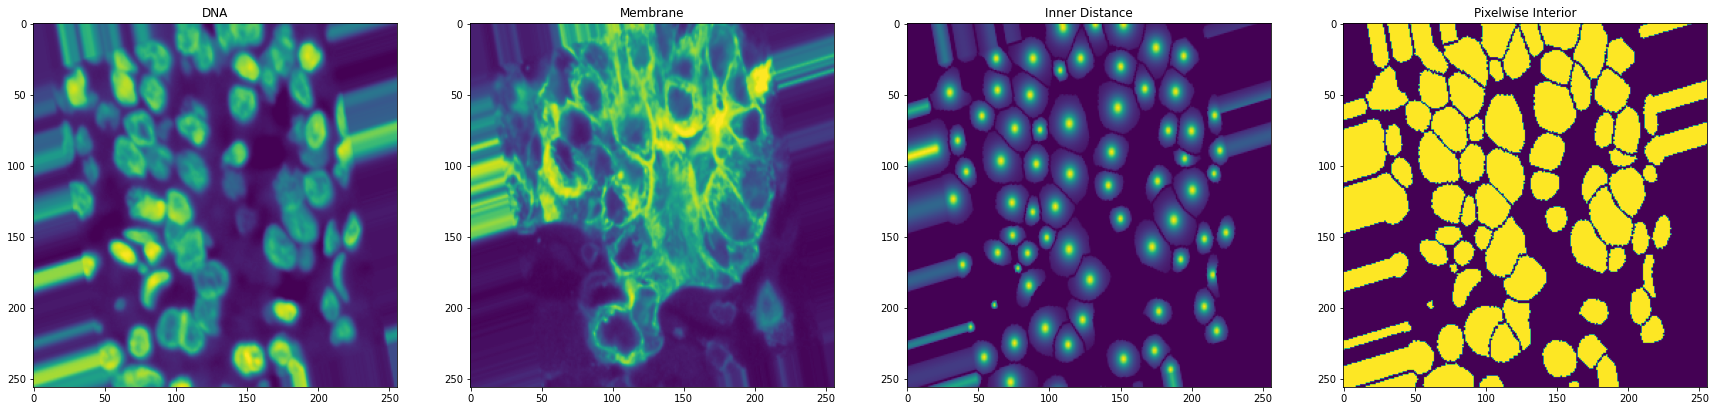

In [10]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
# inner_distance = outputs[0]
# outer_distance = outputs[1]
# fgbg = outputs[2]
# pixelwise = outputs[3]

inner_distance = outputs[0]
pixelwise = outputs[1]


fig, axes = plt.subplots(1, 4, figsize=(30, 30))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('DNA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Membrane')

axes[2].imshow(inner_distance[0, ..., 0].astype('float32'))
axes[2].set_title('Inner Distance')

# axes[3].imshow(outer_distance[0, ..., 0].astype('float32'))
# axes[3].set_title('Outer Distance')

axes[3].imshow(pixelwise[0, ..., 1].astype('float32'))
axes[3].set_title('Pixelwise Interior')

plt.show()

In [11]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [12]:
new_model.compile(loss=loss, optimizer=optimizer)

In [13]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    #tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    #steps_per_epoch=train_data.y.shape[0] // batch_size,
    steps_per_epoch=319,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/250


W1002 19:47:36.623605 139992054073152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


318/319 [============================>.] - ETA: 0s - loss: 0.0413 - semantic_0_loss: 0.0328 - semantic_1_loss: 0.0085
Epoch 00001: val_loss improved from inf to 0.06938, saving model to /data/models/20201002_feature_dropout/20200930_multiplex_deep_watershed_single_batch_lr_4_batch_1.h5
319/319 [==============================] - 84s 264ms/step - loss: 0.0413 - semantic_0_loss: 0.0328 - semantic_1_loss: 0.0085 - val_loss: 0.0694 - val_semantic_0_loss: 0.0363 - val_semantic_1_loss: 0.0331
Epoch 2/250
318/319 [============================>.] - ETA: 0s - loss: 0.0266 - semantic_0_loss: 0.0194 - semantic_1_loss: 0.0072
Epoch 00002: val_loss did not improve from 0.06938
319/319 [==============================] - 25s 78ms/step - loss: 0.0265 - semantic_0_loss: 0.0193 - semantic_1_loss: 0.0072 - val_loss: 0.0699 - val_semantic_0_loss: 0.0340 - val_semantic_1_loss: 0.0359
Epoch 3/250
318/319 [============================>.] - ETA: 0s - loss: 0.0243 - semantic_0_loss: 0.0175 - semantic_1_loss: 0.

Epoch 21/250
318/319 [============================>.] - ETA: 0s - loss: 0.0158 - semantic_0_loss: 0.0109 - semantic_1_loss: 0.0049
Epoch 00021: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0158 - semantic_0_loss: 0.0109 - semantic_1_loss: 0.0049 - val_loss: 0.0214 - val_semantic_0_loss: 0.0118 - val_semantic_1_loss: 0.0096
Epoch 22/250
318/319 [============================>.] - ETA: 0s - loss: 0.0156 - semantic_0_loss: 0.0107 - semantic_1_loss: 0.0049
Epoch 00022: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0156 - semantic_0_loss: 0.0107 - semantic_1_loss: 0.0049 - val_loss: 0.0214 - val_semantic_0_loss: 0.0122 - val_semantic_1_loss: 0.0092
Epoch 23/250
318/319 [============================>.] - ETA: 0s - loss: 0.0153 - semantic_0_loss: 0.0106 - semantic_1_loss: 0.0048
Epoch 00023: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 7

318/319 [============================>.] - ETA: 0s - loss: 0.0135 - semantic_0_loss: 0.0092 - semantic_1_loss: 0.0043
Epoch 00042: val_loss did not improve from 0.01691
319/319 [==============================] - 27s 84ms/step - loss: 0.0135 - semantic_0_loss: 0.0092 - semantic_1_loss: 0.0043 - val_loss: 0.0188 - val_semantic_0_loss: 0.0106 - val_semantic_1_loss: 0.0081
Epoch 43/250
318/319 [============================>.] - ETA: 0s - loss: 0.0139 - semantic_0_loss: 0.0096 - semantic_1_loss: 0.0044
Epoch 00043: val_loss did not improve from 0.01691
319/319 [==============================] - 27s 84ms/step - loss: 0.0139 - semantic_0_loss: 0.0096 - semantic_1_loss: 0.0044 - val_loss: 0.0208 - val_semantic_0_loss: 0.0118 - val_semantic_1_loss: 0.0090
Epoch 44/250
318/319 [============================>.] - ETA: 0s - loss: 0.0135 - semantic_0_loss: 0.0092 - semantic_1_loss: 0.0043
Epoch 00044: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - lo

318/319 [============================>.] - ETA: 0s - loss: 0.0123 - semantic_0_loss: 0.0082 - semantic_1_loss: 0.0040
Epoch 00063: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0123 - semantic_0_loss: 0.0082 - semantic_1_loss: 0.0041 - val_loss: 0.0202 - val_semantic_0_loss: 0.0113 - val_semantic_1_loss: 0.0089
Epoch 64/250
318/319 [============================>.] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0081 - semantic_1_loss: 0.0040
Epoch 00064: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0121 - semantic_0_loss: 0.0081 - semantic_1_loss: 0.0040 - val_loss: 0.0184 - val_semantic_0_loss: 0.0110 - val_semantic_1_loss: 0.0073
Epoch 65/250
318/319 [============================>.] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0081 - semantic_1_loss: 0.0040
Epoch 00065: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - lo

318/319 [============================>.] - ETA: 0s - loss: 0.0110 - semantic_0_loss: 0.0072 - semantic_1_loss: 0.0038
Epoch 00084: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0110 - semantic_0_loss: 0.0071 - semantic_1_loss: 0.0038 - val_loss: 0.0225 - val_semantic_0_loss: 0.0111 - val_semantic_1_loss: 0.0114
Epoch 85/250
318/319 [============================>.] - ETA: 0s - loss: 0.0112 - semantic_0_loss: 0.0074 - semantic_1_loss: 0.0038
Epoch 00085: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0113 - semantic_0_loss: 0.0074 - semantic_1_loss: 0.0038 - val_loss: 0.0213 - val_semantic_0_loss: 0.0113 - val_semantic_1_loss: 0.0100
Epoch 86/250
318/319 [============================>.] - ETA: 0s - loss: 0.0113 - semantic_0_loss: 0.0075 - semantic_1_loss: 0.0038
Epoch 00086: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - lo

318/319 [============================>.] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0068 - semantic_1_loss: 0.0037
Epoch 00105: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0105 - semantic_0_loss: 0.0068 - semantic_1_loss: 0.0037 - val_loss: 0.0219 - val_semantic_0_loss: 0.0113 - val_semantic_1_loss: 0.0106
Epoch 106/250
318/319 [============================>.] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0068 - semantic_1_loss: 0.0037
Epoch 00106: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0104 - semantic_0_loss: 0.0068 - semantic_1_loss: 0.0037 - val_loss: 0.0198 - val_semantic_0_loss: 0.0105 - val_semantic_1_loss: 0.0092
Epoch 107/250
318/319 [============================>.] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0067 - semantic_1_loss: 0.0036
Epoch 00107: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - 

318/319 [============================>.] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0068 - semantic_1_loss: 0.0036
Epoch 00126: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0104 - semantic_0_loss: 0.0067 - semantic_1_loss: 0.0036 - val_loss: 0.0218 - val_semantic_0_loss: 0.0112 - val_semantic_1_loss: 0.0106
Epoch 127/250
318/319 [============================>.] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0068 - semantic_1_loss: 0.0036
Epoch 00127: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0103 - semantic_0_loss: 0.0068 - semantic_1_loss: 0.0036 - val_loss: 0.0214 - val_semantic_0_loss: 0.0107 - val_semantic_1_loss: 0.0107
Epoch 128/250
318/319 [============================>.] - ETA: 0s - loss: 0.0100 - semantic_0_loss: 0.0065 - semantic_1_loss: 0.0036
Epoch 00128: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 79ms/step - 

318/319 [============================>.] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0066 - semantic_1_loss: 0.0036
Epoch 00147: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0101 - semantic_0_loss: 0.0066 - semantic_1_loss: 0.0036 - val_loss: 0.0197 - val_semantic_0_loss: 0.0107 - val_semantic_1_loss: 0.0090
Epoch 148/250
318/319 [============================>.] - ETA: 0s - loss: 0.0100 - semantic_0_loss: 0.0065 - semantic_1_loss: 0.0036
Epoch 00148: val_loss did not improve from 0.01691
319/319 [==============================] - 25s 78ms/step - loss: 0.0101 - semantic_0_loss: 0.0065 - semantic_1_loss: 0.0036 - val_loss: 0.0202 - val_semantic_0_loss: 0.0106 - val_semantic_1_loss: 0.0097
Epoch 149/250
318/319 [============================>.] - ETA: 0s - loss: 0.0096 - semantic_0_loss: 0.0061 - semantic_1_loss: 0.0035
Epoch 00149: val_loss did not improve from 0.01691
319/319 [==============================] - 27s 83ms/step - 

318/319 [============================>.] - ETA: 0s - loss: 0.0099 - semantic_0_loss: 0.0063 - semantic_1_loss: 0.0035
Epoch 00168: val_loss did not improve from 0.01691
319/319 [==============================] - 27s 84ms/step - loss: 0.0099 - semantic_0_loss: 0.0063 - semantic_1_loss: 0.0035 - val_loss: 0.0208 - val_semantic_0_loss: 0.0110 - val_semantic_1_loss: 0.0098
Epoch 169/250
139/319 [============>.................] - ETA: 13s - loss: 0.0101 - semantic_0_loss: 0.0064 - semantic_1_loss: 0.0037

KeyboardInterrupt: 

In [14]:
new_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [16]:
test_dict = np.load(NPZ_DIR + npz_name + 'test_256x256.npz')
X_test = test_dict['X']
y_test = test_dict['y']
tissue_list, platform_list = test_dict['tissue_list'], test_dict['platform_list']
X_test = multiplex_preprocess(X_test)

In [35]:
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation(use_pretrained_weights=False)

In [17]:
inner_distance, pixelwise = new_model.predict(X_test)

In [20]:
small_idx = np.random.choice(range(X_test.shape[0]), 200, replace=False)

In [18]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance': inner_distance,
                                     'pixelwise-interior': pixelwise[:, :, :, 1:2]}, 
                                     maxima_threshold=0.1, maxima_model_smooth=0,
                                    interior_threshold=0.3,
                                    radius=3,
                                    small_objects_threshold=10,
                                     fill_holes_threshold=10)

In [22]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [23]:
RGB_data = make_color_overlay(X_test[small_idx, :, :, :])
true_overlay = make_outline_overlay(RGB_data, y_test[small_idx, :, :, 0])

In [24]:
predicted_overlay = make_outline_overlay(RGB_data, labeled_images[..., 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


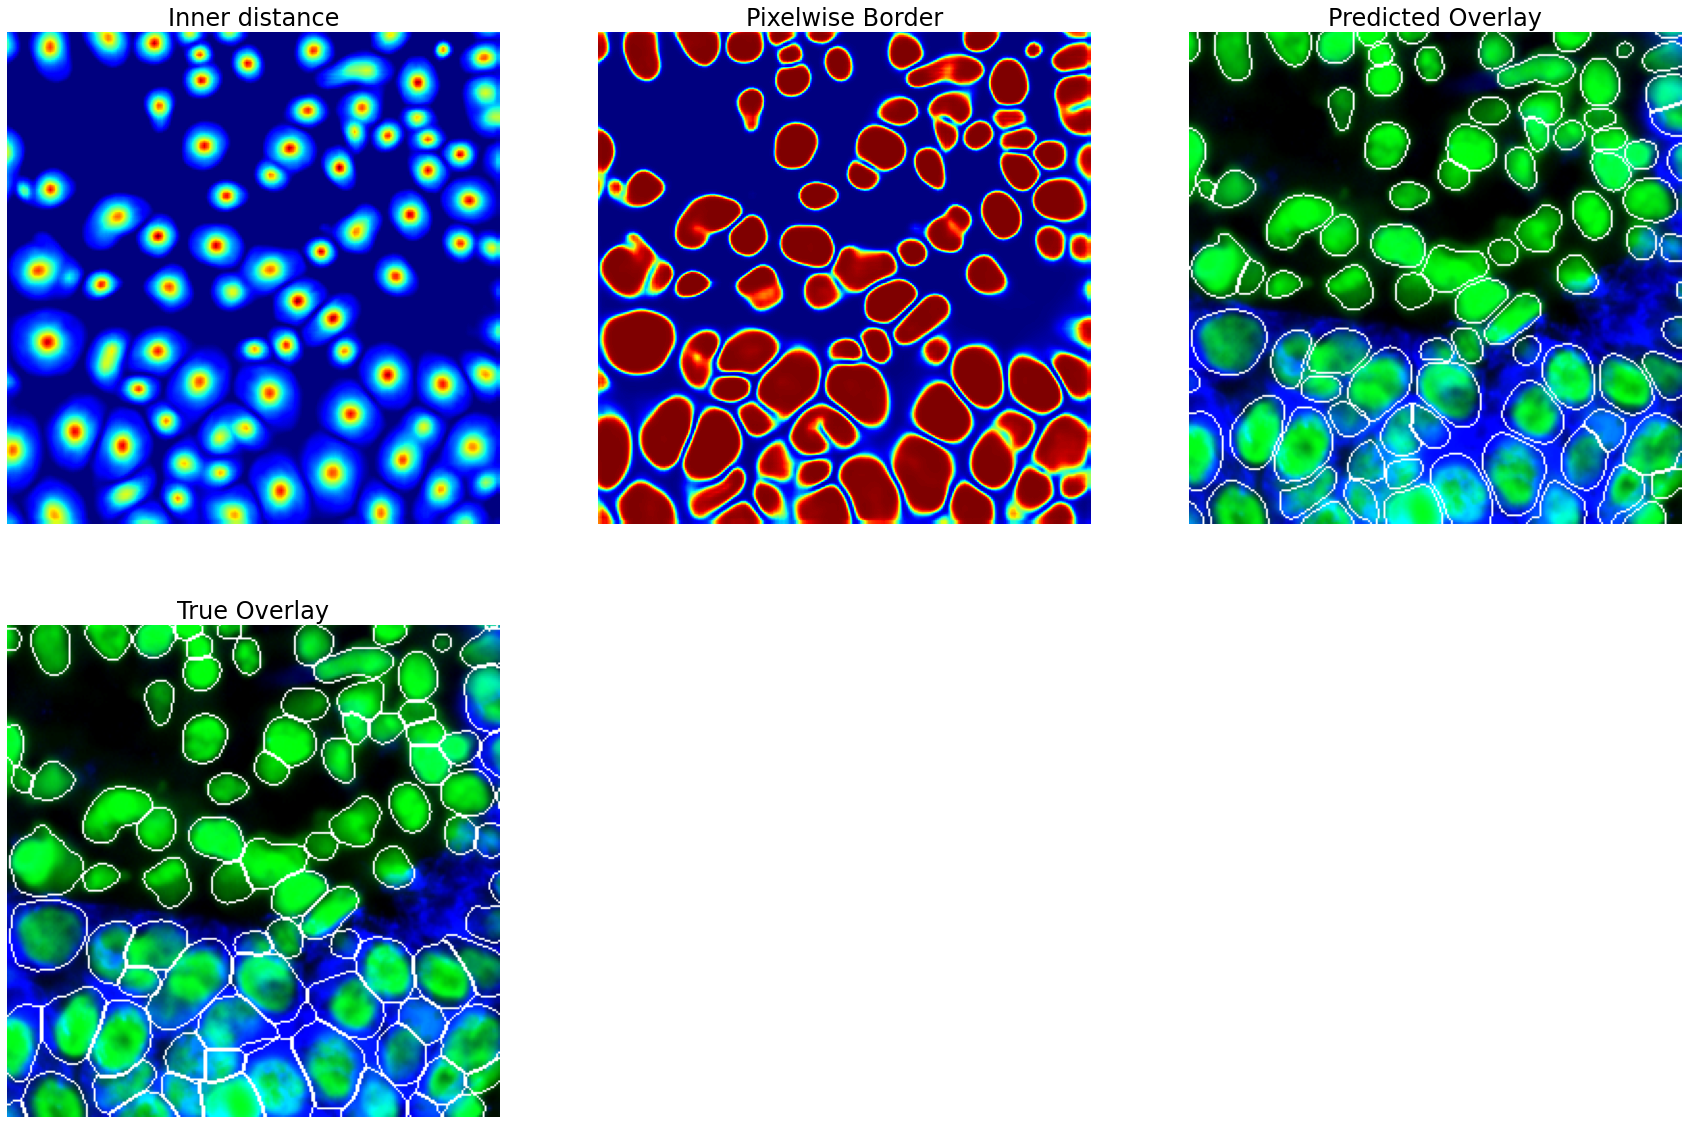

In [31]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 145
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(inner_distance[small_idx[index],...,0], cmap='jet')
axes[1].imshow(pixelwise[small_idx[index],...,1], cmap='jet')
axes[2].imshow(predicted_overlay[index, ...], cmap=cmap)
axes[3].imshow(true_overlay[index, ...], cmap=cmap)

axes[0].set_title('Inner distance', fontsize=24)
axes[1].set_title('Pixelwise Border', fontsize=24)
axes[2].set_title('Predicted Overlay', fontsize=24)
axes[3].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [39]:
len(np.unique(true[true == 5]))

0

In [21]:
db = DatasetBenchmarker(y_true=y_test, 
                       y_pred=labeled_images,
                       tissue_list=tissue_list,
                       platform_list=platform_list,
                       model_name='default_model')
tissue_stats, platform_stats = db.benchmark()


____________Object-based statistics____________

Number of true cells:		 123223
Number of predicted cells:	 104218

Correct detections:  79909	Recall: 64.8491%
Incorrect detections: 24309	Precision: 76.6749%

Gained detections: 11578	Perc Error: 27.7065%
Missed detections: 19590	Perc Error: 46.8795%
Merges: 8725		Perc Error: 20.8792%
Splits: 955		Perc Error: 2.2853%
Catastrophes: 940		Perc Error: 2.2494%

Gained detections from splits: 1016
Missed detections from merges: 11449
True detections involved in catastrophes: 1226
Predicted detections involved in catastrophes: 998 

Average Pixel IOU (Jaccard Index): 0.7728 

uid is breast
uid is gi
uid is immune
uid is lung
uid is pancreas
uid is skin
uid is codex
uid is cycif
uid is mibi
uid is mxif
uid is vectra
uid is all


In [22]:
# 20200930_multiplex: evaluated on 1x test, no phase_preprocess
for key in tissue_stats:
    print('Accuracy of {} is {}'.format(key, tissue_stats[key]['f1']))

print("")
for key in platform_stats:
    print('Accuracy of {} is {}'.format(key, platform_stats[key]['f1']))

Accuracy of breast is 0.6330760078581114
Accuracy of gi is 0.600389996921077
Accuracy of immune is 0.819311509691949
Accuracy of lung is 0.8413178548070633
Accuracy of pancreas is 0.733930462565741
Accuracy of skin is 0.5838935020429683
Accuracy of all is 0.7092982675346946

Accuracy of codex is 0.7222373454446466
Accuracy of cycif is 0.8505824958832853
Accuracy of mibi is 0.6470502718576454
Accuracy of mxif is 0.47580914247580913
Accuracy of vectra is 0.6367255476888604
Accuracy of all is 0.7092982675346946


In [50]:
# 20200930_multiplex: evaluated on 1x test, batch 1 lr -5
for key in tissue_stats:
    print('Accuracy of {} is {}'.format(key, tissue_stats[key]['f1']))

print("")
for key in platform_stats:
    print('Accuracy of {} is {}'.format(key, platform_stats[key]['f1']))

Accuracy of breast is 0.6171857110144264
Accuracy of gi is 0.5129224652087475
Accuracy of immune is 0.8028700287002869
Accuracy of lung is 0.8547772267082018
Accuracy of pancreas is 0.7211225890341689
Accuracy of skin is 0.4267757965507162
Accuracy of all is 0.6768128758401132

Accuracy of codex is 0.7232674480630884
Accuracy of cycif is 0.8558818958818958
Accuracy of mibi is 0.40843964671246324
Accuracy of mxif is 0.46357104971310087
Accuracy of vectra is 0.6253099324225777
Accuracy of all is 0.6768128758401132


In [22]:
# 20200930_multiplex: evaluated on 1x test, batch 1 lr -4
for key in tissue_stats:
    print('Accuracy of {} is {}'.format(key, tissue_stats[key]['f1']))

print("")
for key in platform_stats:
    print('Accuracy of {} is {}'.format(key, platform_stats[key]['f1']))

Accuracy of breast is 0.6575837070886575
Accuracy of gi is 0.580522463040046
Accuracy of immune is 0.8219239282740693
Accuracy of lung is 0.8291723035297011
Accuracy of pancreas is 0.7130969284135228
Accuracy of skin is 0.5407651526006592
Accuracy of all is 0.702678936515404

Accuracy of codex is 0.7411688962014451
Accuracy of cycif is 0.8547027060479941
Accuracy of mibi is 0.522556767030109
Accuracy of mxif is 0.46222979045456697
Accuracy of vectra is 0.6540772121299155
Accuracy of all is 0.702678936515404


In [20]:
# Copyright 2016-2020 The Van Valen Lab at the California Institute of
# Technology (Caltech), with support from the Paul Allen Family Foundation,
# Google, & National Institutes of Health (NIH) under Grant U24CA224309-01.
# All rights reserved.
#
# Licensed under a modified Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.github.com/vanvalenlab/caliban-toolbox/LICENSE
#
# The Work provided may be used for non-commercial academic purposes only.
# For any other use of the Work, including commercial use, please contact:
# vanvalenlab@gmail.com
#
# Neither the name of Caltech nor the names of its contributors may be used
# to endorse or promote products derived from this software without specific
# prior written permission.
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import numpy as np

from deepcell_toolbox.metrics import Metrics, stats_pixelbased
from scipy.stats import hmean


class DatasetBenchmarker(object):
    """Class to perform benchmarking across different tissue and platform types

    Args:
        y_true: true labels
        y_pred: predicted labels
        tissue_list: list of tissue names for each image
        platform_list: list of platform names for each image
        model_name: name of the model used to generate the predictions
        metrics_kwargs: arguments to be passed to metrics package

    Raises:
        ValueError: if y_true and y_pred have different shapes
        ValueError: if y_true and y_pred are not 4D
        ValueError: if tissue_ids or platform_ids is not same length as labels
    """
    def __init__(self,
                 y_true,
                 y_pred,
                 tissue_list,
                 platform_list,
                 model_name,
                 metrics_kwargs={}):
        if y_true.shape != y_pred.shape:
            raise ValueError('Shape mismatch: y_true has shape {}, '
                             'y_pred has shape {}. Labels must have the same'
                             'shape.'.format(y_true.shape, y_pred.shape))
        if len(y_true.shape) != 4:
            raise ValueError('Data must be 4D, supplied data is {}'.format(y_true.shape))

        self.y_true = y_true
        self.y_pred = y_pred

        if len({y_true.shape[0], len(tissue_list), len(platform_list)}) != 1:
            raise ValueError('Tissue_list and platform_list must have same length as labels')

        self.tissue_list = tissue_list
        self.platform_list = platform_list
        self.model_name = model_name
        self.metrics = Metrics(model_name, **metrics_kwargs)

    def _benchmark_category(self, category_ids):
        """Compute benchmark stats over the different categories in supplied list

        Args:
            category_ids: list specifying which category each image belongs to

        Returns:
            stats_dict: dictionary of benchmarking results
        """

        unique_ids = np.unique(category_ids)

        # create dict to hold stats across each category
        stats_dict = {}
        for uid in unique_ids:
            print("uid is {}".format(uid))
            stats_dict[uid] = {}
            category_idx = np.isin(category_ids, uid)

            # sum metrics across individual images
            for key in self.metrics.stats:
                stats_dict[uid][key] = self.metrics.stats[key][category_idx].sum()

            # compute additional metrics not produced by Metrics class
            stats_dict[uid]['recall'] = \
                stats_dict[uid]['correct_detections'] / stats_dict[uid]['n_true']

            stats_dict[uid]['precision'] = \
                stats_dict[uid]['correct_detections'] / stats_dict[uid]['n_pred']

            stats_dict[uid]['f1'] = \
                hmean([stats_dict[uid]['recall'], stats_dict[uid]['precision']])

            pixel_stats = stats_pixelbased(self.y_true[category_idx] != 0,
                                           self.y_pred[category_idx] != 0)
            stats_dict[uid]['jaccard'] = pixel_stats['jaccard']

        return stats_dict

    def benchmark(self):
        self.metrics.calc_object_stats(self.y_true, self.y_pred)
        tissue_stats = self._benchmark_category(category_ids=self.tissue_list)
        platform_stats = self._benchmark_category(category_ids=self.platform_list)
        all_stats = self._benchmark_category(category_ids=['all'] * len(self.tissue_list))
        tissue_stats['all'] = all_stats['all']
        platform_stats['all'] = all_stats['all']

        return tissue_stats, platform_stats